In [2]:
from HeaderP import *

In [3]:
import Astraea

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

from scipy.signal import savgol_filter

# load simulation

In [4]:
Rcut_thread=25
data=pd.read_pickle('../TNGRbirth/Tobias/g8.26e11.pkl')
data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
data['R']=np.sqrt(data['x']**2+data['y']**2)


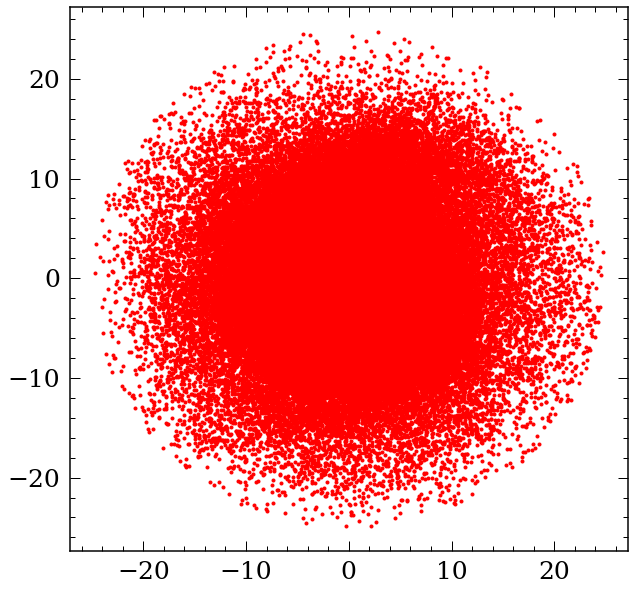

In [5]:
plt.plot(data['x'],data['y'],'r.')

In [6]:
m_sr = (data['Rbir']>7)&(data['Rbir']<9)
data_sr = data[m_sr]

In [7]:
snapshotnames = np.load('../TNGRbirth/Tobias/snapshots.npy')
ages = np.load('../TNGRbirth/Tobias/cosmictime.npy')

In [8]:
agelookup = {snapshotnames[i]:ages[i] for i in range(len(ages))}

In [9]:
xcols = [i for i in data_sr.columns if 'x_' in i] 
ycols = [i for i in data_sr.columns if 'y_' in i] 
zcols = [i for i in data_sr.columns if 'z_' in i] 

xcols = [i for i in xcols if 'vx_' not in i]
ycols = [i for i in ycols if 'vy_' not in i] 
zcols = [i for i in zcols if 'vz_' not in i] 

snaps = [i.split('_')[-1] for i in xcols]

In [10]:
dr = np.zeros(0)
cosmictime = np.zeros(0)
IDs = np.zeros(0)
for i in range(len(snaps)):
    data_snap = data_sr.dropna(subset=[xcols[i],ycols[i]])
    IDs = np.append(IDs, data_snap['iord'])
    R = np.sqrt(data_snap[xcols[i]]**2+data_snap[ycols[i]]**2).values
    Rb = data_snap['Rbir'].values
    dr = np.append(dr, R-Rb)
    cosmictime = np.append(cosmictime, np.ones(len(data_snap))*agelookup[snaps[i]])

In [11]:
print(len(IDs))
IDs = pd.Series(IDs).drop_duplicates(keep='first').values
print(len(IDs))

294001
12292


In [12]:
def SlideMed(age, dr, window, slide):
    age, dr = np.array(age), np.array(dr)
    minage, maxage = min(age), max(age)
    npoints = int((maxage-minage)/slide)
    medage = np.zeros(npoints)*np.nan
    meddr = np.zeros(npoints)*np.nan
    for i in trange(npoints):
        if i==0:
            m_w = (age<window)
        elif i==npoints-1:
            m_w = (age>(maxage-window))
        else:
            m_w = ((age>(i*slide-window+minage))&(age<(i*slide+window+minage)))
        #print(sum(m_w))
        medage[i], meddr[i] = np.median(age[m_w]), np.median(dr[m_w])
    m_nan = (meddr==meddr)
    medage, meddr = medage[m_nan], meddr[m_nan]
    return medage, meddr
        

In [27]:
# get PSD for each star
xfs = np.zeros(0)
PSDs = np.zeros(0)

ages_PSD = np.array([agelookup[j] for j in snaps])
numb = np.zeros(len(IDs))
for i in trange(len(IDs)):
    data_star = data.loc[data['iord']==IDs[i]]
    
    R = np.sqrt(data_star[xcols].values[0]**2+data_star[ycols].values[0]**2)
    drs = R-data_star['Rbir'].values
    
    m = (drs==drs)
    age, drs = ages_PSD[m], drs[m]

    numb[i] = len(age)
    if len(age)<40:
        continue
    # do fft
    N = len(age)
    T = max(age)/N
    yf = fft(drs)
    xfs = np.append(xfs,fftfreq(N, T)[:N//2])
    FFTp = 2.0/N * np.abs(yf[0:N//2])
    PSDs = np.append(PSDs, FFTp**2)


100%|██████████| 12292/12292 [00:12<00:00, 962.16it/s]


In [96]:
# with NUFFT
from pynufft import NUFFT
NufftObj = NUFFT()

# get PSD for each star
xfs = np.zeros(0)
PSDs = np.zeros(0)

ages_PSD = np.array([agelookup[j] for j in snaps])
numb = np.zeros(len(IDs))
for i in trange(len(IDs)):
    data_star = data.loc[data['iord']==IDs[i]]
    
    R = np.sqrt(data_star[xcols].values[0]**2+data_star[ycols].values[0]**2)
    drs = R-data_star['Rbir'].values
    
    m = (drs==drs)
    age, drs = ages_PSD[m], drs[m]

    numb[i] = len(age)
    if len(age)<30:
        continue
        
    om = np.zeros((len(age),1))
    om[:,0] = (1/((age-min(age))/max(age)))*np.pi*2-np.pi
    Nd = (len(age),)
    Kd = (len(age),)
    Jd = (1,)
    NufftObj.plan(om, Nd, Kd, Jd)

    nufft_freq_data =NufftObj.forward(drs)
    FFTp = np.abs(nufft_freq_data[0:len(age)//2])

    N = len(age)
    xfs = np.append(xfs,(om[:N//2,0]+np.pi)/np.pi*2)
    FFTp = np.abs(nufft_freq_data[:N//2])
    PSDs = np.append(PSDs, FFTp**2)



  0%|          | 0/12292 [00:00<?, ?it/s]<ipython-input-96-84690d858073>:25: RuntimeWarning: divide by zero encountered in true_divide
  om[:,0] = (1/((age-min(age))/max(age)))*np.pi*2-np.pi
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pynufft/src/_helper/helper.py:1430: RuntimeWarning: invalid value encountered in subtract
  dk = 1.0 * om / gam - nufft_offset0  # om/gam -  nufft_offset , [M,1]
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pynufft/src/_helper/helper.py:157: RuntimeWarning: invalid value encountered in multiply
  phase0= numpy.exp( - 1.0j*omd*N/2.0)
100%|██████████| 12292/12292 [00:58<00:00, 211.70it/s]


  0%|          | 0/4854 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4854/4854 [00:00<00:00, 6136.61it/s]


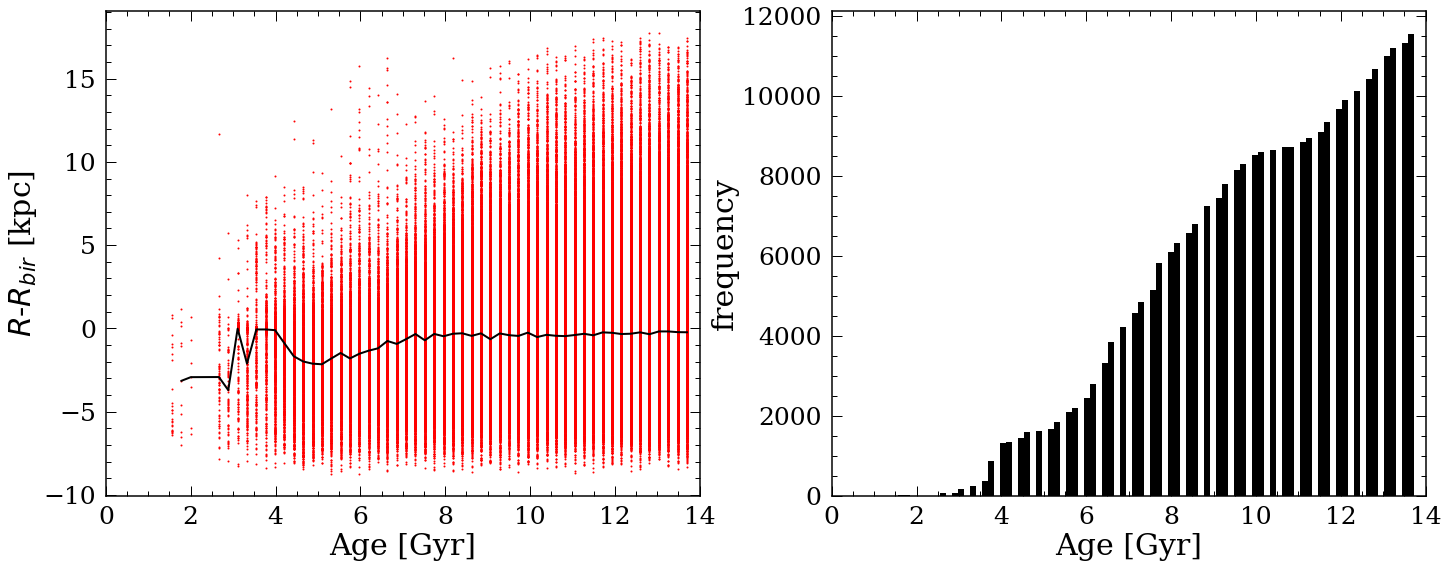

In [29]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
age_order, dr_order = zip(*sorted(zip(cosmictime, dr)))
plt.scatter(age_order, dr_order,s=1,c='r')
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,14])

plt.subplot(1,2,2)
plt.hist(age_order,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,14])
plt.tight_layout()

In [97]:
m = (PSDs==PSDs)
xfs, PSDs = xfs[m], PSDs[m]

  0%|          | 0/24 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 24/24 [00:00<00:00, 3651.32it/s]


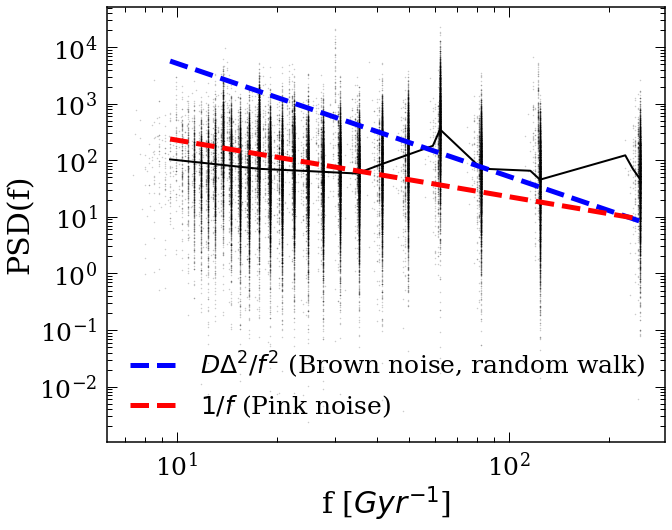

In [98]:
# do every star
plt.figure(figsize=(10,8))
plt.loglog(np.array(xfs), np.array(PSDs), 'k.', markersize=1,alpha=0.2)
xfs_smooth, PSDs_smooth = SlideMed(xfs, PSDs, 10, 10)
plt.loglog(xfs_smooth, PSDs_smooth, 'k-')
#plt.ylim([1,1e4])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')

A2 = 1e7
A1 = 1e4
plt.plot(xfs_smooth, A2*np.mean(np.diff(ages))**2/xfs_smooth**2, 'b--',label='$DΔ^2/f^2$ (Brown noise, random walk)',linewidth=5)
plt.plot(xfs_smooth, A1*np.mean(np.diff(ages))/xfs_smooth, 'r--',label='$1/f$ (Pink noise)',linewidth=5)

plt.legend()



<ipython-input-99-ced44a4ee1ab>:18: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, D*Delta**2/xf**2, 'b--',label='$DΔ^2/f^2$ (Brown noise, random walk)',linewidth=5)


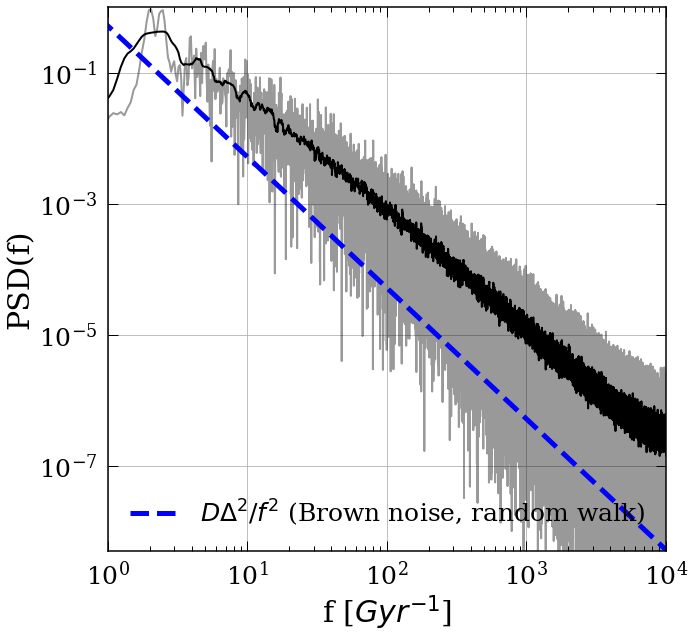

In [99]:
N = len(age_order)
T = max(age_order)/N
yf = fft(dr_order)


xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
PSD = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf,PSD**2,'k-',alpha=0.4)

#PSD_smooth = gaussian_filter1d(PSD, 5)
PSD_smooth = savgol_filter(PSD**2, 21, 1)
plt.loglog(xf, PSD_smooth,'k-')

Delta = np.mean(np.diff(ages))
D = 10
plt.plot(xf, D*Delta**2/xf**2, 'b--',label='$DΔ^2/f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([1,1e4])
plt.ylim([5e-9,1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [100]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 14, 1000)
#power = LombScargle(data_sr['age'], data_sr['dR']).power(frequency)
power = LombScargle(age_smooth, dr_smooth).power(2*np.pi/periods)

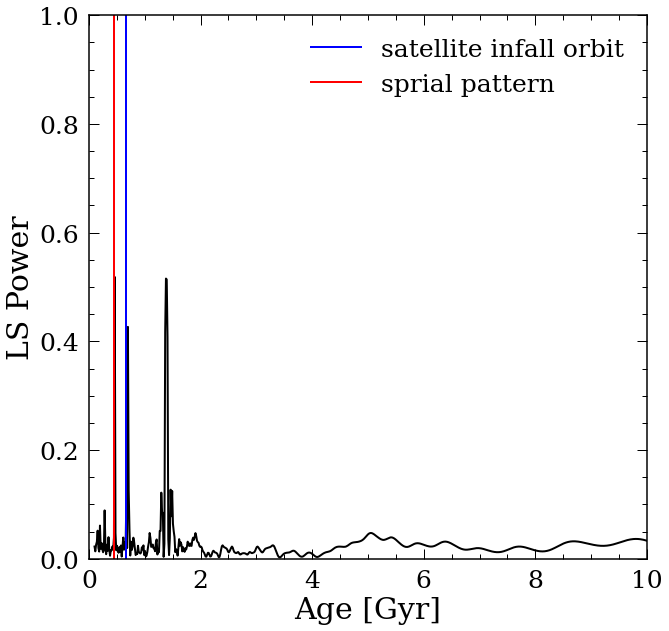

In [101]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,1])
plt.xlim([0,10])
plt.plot([0.66,0.66],[0,1],'b-',label='satellite infall orbit')
plt.plot([0.44,0.44],[0,1],'r-',label='sprial pattern')
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')
plt.legend()

# Use the last snapshot

<ipython-input-108-f44abd308846>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sr['dR'] = data_sr['R']-data_sr['Rbir']
  0%|          | 0/1298 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1298/1298 [00:00<00:00, 11072.55it/s]


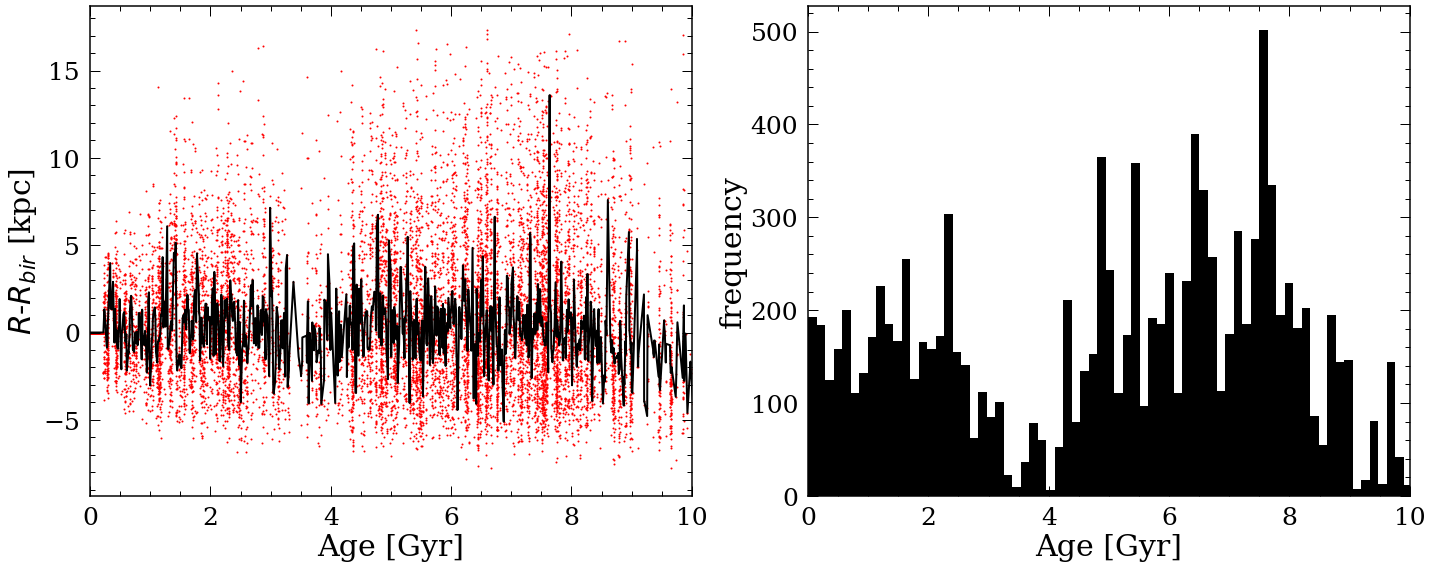

In [108]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
m = ((data['Rbir']>7)&(data['Rbir']<9))
data_sr=data[m]
data_sr['dR'] = data_sr['R']-data_sr['Rbir']
plt.subplot(1,2,1)
age_order_sel, dr_order_sel = zip(*sorted(zip(data_sr['age'],data_sr['dR'])))
plt.scatter(age_order_sel, dr_order_sel,s=1,c='r')
age_smooth_sel, dr_smooth_sel = SlideMed(data_sr['age'].values, data_sr['dR'].values, 0.01, 0.01)
plt.plot(age_smooth_sel, dr_smooth_sel,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(age_order_sel,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,10])
plt.tight_layout()

<ipython-input-109-babcf2905ba9>:23: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xf, D*Delta**2/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)


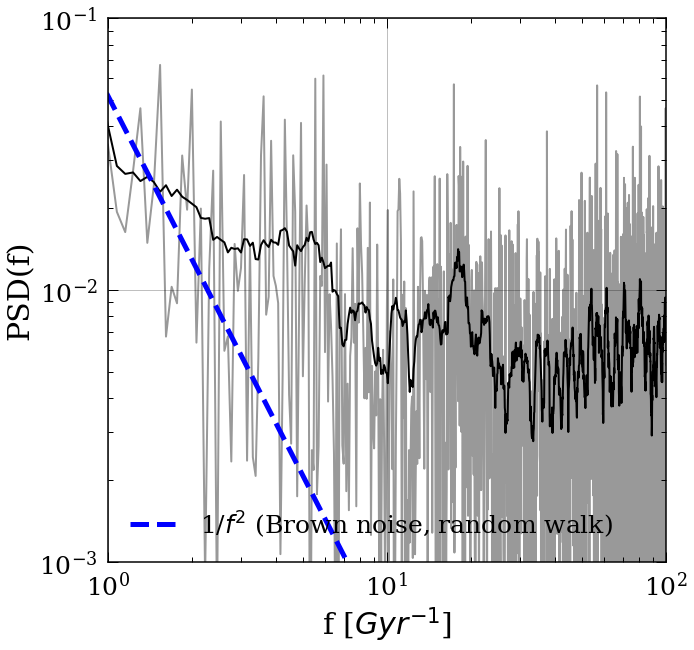

In [109]:

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

N = len(age_order_sel)
T = max(age_order_sel)/N
yf = fft(dr_order_sel)
"""
N = len(age_smooth_sel)
T = max(age_smooth_sel)/N
yf = fft(dr_smooth_sel)
"""

xf_sel = fftfreq(N, T)[:N//2]


PSD_sel = 2.0/N * np.abs(yf[0:N//2])
plt.loglog(xf_sel,PSD_sel**2,'k-',alpha=0.4)

PSD_smooth_sel = savgol_filter(PSD_sel**2, 21, 1)
plt.loglog(xf_sel,PSD_smooth_sel,'k-')

D = 1
plt.plot(xf, D*Delta**2/xf**2, 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([1,1/0.01])
plt.ylim([1e-3,1e-1])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [110]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 10, 1000)
power = LombScargle(age_order_sel, dr_order_sel).power(2*np.pi/periods)

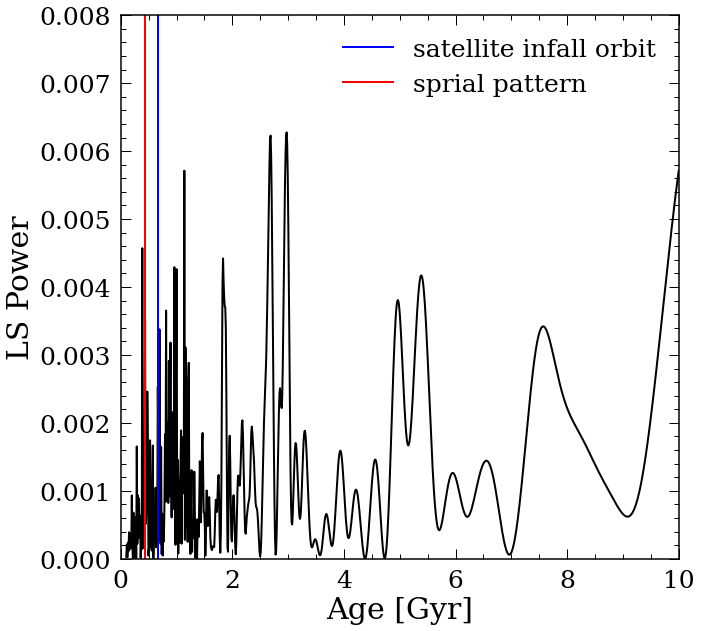

In [111]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.008])
plt.xlim([0,10])
plt.plot([0.66,0.66],[0,1],'b-',label='satellite infall orbit')
plt.plot([0.44,0.44],[0,1],'r-',label='sprial pattern')
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')
plt.legend()

# make movie

In [ ]:
data=pd.read_pickle('./Tobias/g8.26e11.pkl')

In [85]:
data_onestar = data.dropna(subset=[xcols[0],ycols[0]]).sort_values(by='y').reset_index(drop=True).iloc[-1]

for i in trange(len(snaps)):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.plot(data[xcols[i]],data[ycols[i]],'r.')
    plt.plot(data_onestar[xcols[i]],data_onestar[ycols[i]],'b.')
    plt.xlim([-50,50])
    plt.ylim([-50,50])
    plt.title('Time: %.2f Gyr'%agelookup[snaps[i]],fontsize=25)
    
    plt.subplot(1,2,2)
    plt.plot(data[xcols[i]],data[zcols[i]],'r.')
    plt.plot(data_onestar[xcols[i]],data_onestar[zcols[i]],'b.')
    plt.xlim([-50,50])
    plt.ylim([-20,20])
    plt.savefig('./Tobias_movie/'+str(i)+'.png')
    plt.close()

100%|██████████| 59/59 [00:48<00:00,  1.22it/s]


In [86]:
(3.11-2.89)*2

0.4399999999999995

In [87]:
5.53-4.87

0.6600000000000001

## Check if angular momentum is consistant

In [12]:
xcols = [i for i in data.columns if 'x_' in i] 
ycols = [i for i in data.columns if 'y_' in i] 
zcols = [i for i in data.columns if 'z_' in i] 

xcols = [i for i in xcols if 'vx_' not in i]
ycols = [i for i in ycols if 'vy_' not in i] 
zcols = [i for i in zcols if 'vz_' not in i] 

vxcols = [i for i in data.columns if 'vx_' in i]
vycols = [i for i in data.columns if 'vy_' in i] 
vzcols = [i for i in data.columns if 'vz_' in i] 

masscols = [i for i in data.columns if 'mass_' in i]
snaps = [i.split('_')[-1] for i in xcols]

print(np.shape(xcols),np.shape(vxcols))

(59,) (59,)


In [13]:
Lz = np.zeros((len(snaps),3))
for i in trange(len(snaps)):
    data_snap = data.dropna(subset=[xcols[i],ycols[i],zcols[i],vxcols[i],vycols[i],vzcols[i]])
    x, y, z, vx, vy, vz = data_snap[xcols[i]].values, data_snap[ycols[i]].values, data_snap[zcols[i]].values, data_snap[vxcols[i]].values, data_snap[vycols[i]].values, data_snap[vzcols[i]].values
    mass = data_snap[masscols[i]].values
    for j in range(len(x)):
        Lz[i,:] = Lz[i,:] + np.cross([x[j],y[j],z[j]], [vx[j],vy[j],vz[j]])*mass[j]
        

100%|██████████| 59/59 [11:31<00:00, 11.72s/it]


In [16]:
ages_Lz = np.zeros(len(snaps))
for i in range(len(snaps)):
    ages_Lz[i] = agelookup[snaps[i]]

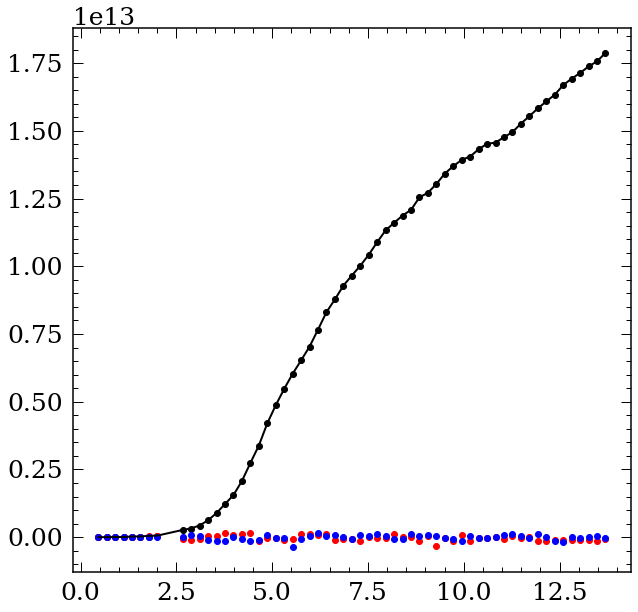

In [17]:
plt.figure()
plt.plot(ages_Lz , Lz[:,-1], 'ko')
plt.plot(ages_Lz , Lz[:,-2], 'ro')
plt.plot(ages_Lz , Lz[:,-3], 'bo')
plt.plot(ages_Lz, np.sqrt([sum(Lz[i,:]**2) for i in range(len(Lz[:,0]))]), 'k-')